### Imports, activate GPU, load dataset

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
# !pip install keras_cv

In [68]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras_cv
from matplotlib import pyplot as plt
%matplotlib inline


gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [69]:
#1. get mnist from tensorflow_datasets
mnist_dataset, info = tfds.load("mnist", split=['train', 'test'], as_supervised=True, with_info=True)
mnist_ds = mnist_dataset

train_ds = mnist_dataset[0]
val_ds = mnist_dataset[1]
# print(info)
# tfds.show_examples(train_ds, info)

### Prepare Dataset

y : -3


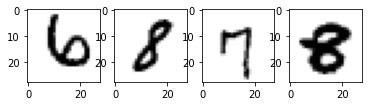

In [70]:
def prepare_rnn_dataset(data) :
  data = data.map(lambda img, target : (tf.cast(img, tf.float32), tf.cast(target, tf.float32)))
  data = data.map(lambda img, target : ((img - 128.)/64., target))

  data = data.batch(4)
  data = data.map(lambda img, target : (img, tf.reduce_sum(target[0::2]) - tf.reduce_sum(target[1::2])))
  
  data = data.cache()
  data = data.shuffle(1000, seed=42)
  data = data.batch(32)
  data = data.prefetch(10)
  return data

train = train_ds.apply(prepare_rnn_dataset)
val  = val_ds.apply(prepare_rnn_dataset)

x, y = next(iter(train))
fig, ax = plt.subplots(1, 4)
ax = ax.flatten()
for i in range(4):
  image = np.reshape(x[0,i,...], (28, 28))
  ax[i].imshow(image, cmap='gray_r')
print("y :", int(y[0,...]))

### LSTM layer

In [72]:
class AbstractLSTMCell(tf.keras.layers.AbstractRNNCell) :
  def __init__(self, cell_size, **kwargs) :
    super().__init__(**kwargs)
    self.cell_size = cell_size
    self.W_f = tf.keras.layers.Dense(self.cell_size, kernel_regularizer=tf.keras.regularizers.L2(), activation='sigmoid')
    self.W_i = tf.keras.layers.Dense(self.cell_size, kernel_regularizer=tf.keras.regularizers.L2(), activation='sigmoid')
    self.W_g = tf.keras.layers.Dense(self.cell_size, kernel_regularizer=tf.keras.regularizers.L2(), activation='tanh')
    self.W_o = tf.keras.layers.Dense(self.cell_size, kernel_regularizer=tf.keras.regularizers.L2(), activation='sigmoid')
  
  @property
  def state_size(self) :
    return [tf.TensorShape([self.cell_size]), tf.TensorShape([self.cell_size])]
  
  @property
  def output_size(self) :
    return [tf.TensorShape([self.cell_size])]
  
  def get_initial_state(self, inputs=None, batch_size=None, dtype=None) :
    return [tf.zeros((batch_size, self.cell_size), dtype=dtype), 
            tf.zeros((batch_size, self.cell_size), dtype=dtype)]

  def call(self, X, states) :
    C_old, H_old = states
    # forget gate
    f_t = self.W_f( tf.concat([X, H_old], axis=1) )
    # input gate
    i_t = self.W_i( tf.concat([X, H_old], axis=1) )
    # output gate
    o_t = self.W_o( tf.concat([X, H_old], axis=1) )
    # cell gate
    g_t = self.W_g( tf.concat([X, H_old], axis=1) )
    # state update
    C_new = f_t * C_old + i_t * g_t
    H_new = o_t * tf.nn.tanh(C_new)
    return H_new, [C_new, H_new]
  
LSTM = lambda n: tf.keras.layers.RNN(AbstractLSTMCell(n), return_sequences=False, unroll=True)
lstm = LSTM(10)
# print(lstm(tf.ones((32, 4, 10))))

### CNN layer

In [73]:
class Colvolution(tf.keras.layers.Layer) :
  def __init__(self, **kwargs) :
    super().__init__(**kwargs)
    self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
    self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
    self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)
    self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
    self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
    self.global_pool = tf.keras.layers.GlobalAvgPool2D()
    self.out = tf.keras.layers.Dense(10, activation='softmax')

    # (28, 28) -> (28, 28)
    self.conv_1 = tf.keras.layers.Conv2D(filters=24, kernel_size=(3, 3), padding='same', 
                                          activation='relu', kernel_regularizer=tf.keras.regularizers.L2())
    # (28, 28) -> (28, 28)
    self.conv_2 = tf.keras.layers.Conv2D(filters=24, kernel_size=(3, 3), padding='same', 
                                          activation='relu', kernel_regularizer=tf.keras.regularizers.L2())
    # (28, 28) -> (14, 14)
    self.pool = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2) 
    # (14, 14) -> (14, 14)
    self.conv_3 = tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), padding='same', 
                                          activation='relu', kernel_regularizer=tf.keras.regularizers.L2())
    # (14, 14) -> (14, 14)
    self.conv_4 = tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), padding='same', 
                                          activation='relu', kernel_regularizer=tf.keras.regularizers.L2())
    self.global_pool = tf.keras.layers.GlobalAvgPool2D()
    self.flatten = tf.keras.layers.Flatten()
    self.affine_1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2())
    self.affine_2 = tf.keras.layers.Dense(10,  activation='softmax', kernel_regularizer=tf.keras.regularizers.L2())

  def call(self, x, training=True) :
    y = self.conv_1(x, training=training)
    y = self.conv_2(x, training=training)
    y = self.pool(y, training=training)
    y = self.conv_3(y, training=training)
    y = self.conv_4(y, training=training)
    y = self.global_pool(y, training=training)
    y = self.flatten(y, training=training)
    y = self.affine_1(y, training=training)
    y = self.affine_2(y, training=training)
    return y

### Calculator model

In [74]:
class Calculator(tf.keras.Model) :
  def __init__(self, **kwargs) :
    super().__init__(**kwargs)

    self.metrics_list = [ tf.keras.metrics.CategoricalAccuracy(name="acc"), 
                          tf.keras.metrics.Mean(name="loss") ]

    self.cv = tf.keras.layers.TimeDistributed(Colvolution())
    self.lstm = LSTM(10)
    self.affine = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2())
    self.loss = tf.keras.losses.MeanSquaredError()
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  
  def reset_metrics(self) :
    for metric in self.metrics_list :
      metric.reset_state()
  
  @tf.function
  def call(self, x, training=False) :
    for layer in self.layers :
      x = layer(x, training=training)
    return x
  
  def call(self, x, training=False) :
    y = self.cv(x)
    y = self.lstm(y)
    y = self.affine(y)
    return y
  
  @ property
  def metrics(self) :
    return self.metrics_list

  def reset_metrics(self) :
    for metric in self.metrics :
      metric.reset_state()
  
  @tf.function
  def train_step(self, data):
    x, t = data
    with tf.GradientTape() as tape:
      output = self(x, training=True)
      loss = self.loss(t, output)
        
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    
    ## update the state of the metrics according to loss
    self.metrics[0].update_state(t, output)
    self.metrics[1].update_state(loss)
    ## return a dictionary with metric names as keys and metric results as values
    return {m.name : m.result() for m in self.metrics}

  ## 6. test_step method
  @tf.function
  def test_step(self, data):
    x, t = data
    ## same as train step (without parameter updates)
    output = self(x, training=False)
    loss = self.loss(t, output)

    self.metrics[0].update_state(t, output)
    self.metrics[1].update_state(loss)
    return {m.name : m.result() for m in self.metrics}

def try_model(model, ds):
  for x, t in ds.take(5):
    y = model(x)


model = Calculator()
x, y = batch = next(iter(train))

try_model(model, train)
model.summary()

Model: "calculator_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  multiple                 39242     
 tributed)                                                       
                                                                 
 rnn_19 (RNN)                multiple                  840       
                                                                 
 dense_104 (Dense)           multiple                  11        
                                                                 
Total params: 40,097
Trainable params: 40,093
Non-trainable params: 4
_________________________________________________________________


### Summary writer, training loop, smooth function

In [75]:
import datetime
def create_summary_writers(config_name):
  # Define where to save the logs
  # along with this, you may want to save a config file with the same name so you know what the hyperparameters were used
  # alternatively make a copy of the code that is used for later reference
  current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  train_log_path = f"logs/{config_name}/{current_time}/train"
  val_log_path = f"logs/{config_name}/{current_time}/val"

  # log writer for training metrics
  train_summary_writer = tf.summary.create_file_writer(train_log_path)
  # log writer for validation metrics
  val_summary_writer = tf.summary.create_file_writer(val_log_path)
  return train_summary_writer, val_summary_writer

train_summary_writer, val_summary_writer = create_summary_writers(config_name="RUN1")

In [76]:
import pprint
import tqdm

def training_loop(model, n_epochs, train, test, train_summary_writer, val_summary_writer, save_path) :
  training_metrics = {metric.name: [] for metric in model.metrics}
  testing_metrics = {metric.name: [] for metric in model.metrics}

  for e in range(n_epochs) :
    train = train.shuffle(buffer_size=5)
    print(f"Epoch {e}:")

    for batch in tqdm.tqdm(train, position=0, leave=True):
      metrics = model.train_step(batch)
      for name, value in metrics.items() :
        training_metrics[name].append(value)
      
      # logging the validation metrics to the log file which is used by tensorboard
      with train_summary_writer.as_default():
        for metric in model.metrics:
          tf.summary.scalar(f"{metric.name}", metric.result(), step=e)

    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
    
    # 4. reset metric objects
    model.reset_metrics()

    # 5. evaluate on validation data
    for batch in test:
      metrics = model.test_step(batch)
      for name, value in metrics.items() :
        testing_metrics[name].append(value)
      # 6. log validation metrics
      with val_summary_writer.as_default() :
          # for scalar metrics:
          for metric in model.metrics:
                  tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
        
    print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])
    # 7. reset metric objects
    model.reset_metrics()

  # 8. save model weights if save_path is given
  if save_path:
    model.save_weights(save_path)
  
  metrics = {metric.name: [training_metrics[metric.name], testing_metrics[metric.name]] for metric in model.metrics}
  return metrics

In [77]:
def smooth(data, level):
    assert level > 1
    data = np.array([data[0]] * (level//2) + data + [data[-1]] * (level//2 - ((level + 1)%2)))
    kernel = np.array([1/level] * level)
    return np.convolve(kernel, data, 'valid')

### Training, Evaluation

In [78]:
metrics = training_loop(model, 15, 
          train, val, 
          train_summary_writer, val_summary_writer, 
          "regularized_model_label_smoothing")

Epoch 0:


100%|██████████| 469/469 [02:21<00:00,  3.30it/s]


['acc: 0.04904051125049591', 'loss: 33.57524108886719']
['val_acc: 0.050632912665605545', 'val_loss: 33.225128173828125']
Epoch 1:


100%|██████████| 469/469 [01:26<00:00,  5.40it/s]


['acc: 0.08528784662485123', 'loss: 33.55400848388672']
['val_acc: 0.08860759437084198', 'val_loss: 32.35953903198242']
Epoch 2:


100%|██████████| 469/469 [02:21<00:00,  3.30it/s]


['acc: 0.27718549966812134', 'loss: 19.581789016723633']
['val_acc: 0.3164556920528412', 'val_loss: 12.269980430603027']
Epoch 3:


100%|██████████| 469/469 [02:21<00:00,  3.30it/s]


['acc: 0.40724948048591614', 'loss: 8.117724418640137']
['val_acc: 0.5063291192054749', 'val_loss: 6.014912128448486']
Epoch 4:


100%|██████████| 469/469 [02:21<00:00,  3.30it/s]


['acc: 0.5351812243461609', 'loss: 5.183631896972656']
['val_acc: 0.5189873576164246', 'val_loss: 4.389676094055176']
Epoch 5:


100%|██████████| 469/469 [01:27<00:00,  5.35it/s]


['acc: 0.6396588683128357', 'loss: 3.857922077178955']
['val_acc: 0.607594907283783', 'val_loss: 3.803086280822754']
Epoch 6:


100%|██████████| 469/469 [02:21<00:00,  3.30it/s]


['acc: 0.5906183123588562', 'loss: 3.246358633041382']
['val_acc: 0.594936728477478', 'val_loss: 3.300720691680908']
Epoch 7:


100%|██████████| 469/469 [02:21<00:00,  3.30it/s]


['acc: 0.6375266313552856', 'loss: 2.718902349472046']
['val_acc: 0.5443037748336792', 'val_loss: 2.5672483444213867']
Epoch 8:


100%|██████████| 469/469 [02:21<00:00,  3.30it/s]


['acc: 0.6993603706359863', 'loss: 2.3248744010925293']
['val_acc: 0.6708860993385315', 'val_loss: 2.304692029953003']
Epoch 9:


100%|██████████| 469/469 [01:31<00:00,  5.13it/s]


['acc: 0.6780383586883545', 'loss: 2.07446551322937']
['val_acc: 0.7848101258277893', 'val_loss: 2.246089458465576']
Epoch 10:


100%|██████████| 469/469 [01:27<00:00,  5.39it/s]


['acc: 0.7313432693481445', 'loss: 1.8190908432006836']
['val_acc: 0.7721518874168396', 'val_loss: 1.8521597385406494']
Epoch 11:


100%|██████████| 469/469 [02:21<00:00,  3.30it/s]


['acc: 0.7078891396522522', 'loss: 1.661988615989685']
['val_acc: 0.7594936490058899', 'val_loss: 1.7504363059997559']
Epoch 12:


100%|██████████| 469/469 [01:27<00:00,  5.36it/s]


['acc: 0.7611940503120422', 'loss: 1.4418754577636719']
['val_acc: 0.8101266026496887', 'val_loss: 1.571825385093689']
Epoch 13:


100%|██████████| 469/469 [02:21<00:00,  3.30it/s]


['acc: 0.7590618133544922', 'loss: 1.396896481513977']
['val_acc: 0.8101266026496887', 'val_loss: 1.523413896560669']
Epoch 14:


100%|██████████| 469/469 [02:21<00:00,  3.30it/s]


['acc: 0.7739872336387634', 'loss: 1.266895055770874']
['val_acc: 0.8481012582778931', 'val_loss: 1.4158223867416382']


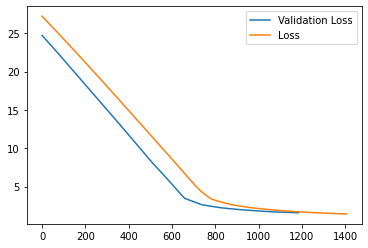

In [79]:
from matplotlib import pyplot as plt
%matplotlib inline
level = 1000

plt.plot(smooth(metrics["loss"][1], level))
plt.plot(smooth(metrics["loss"][0][0::5], level))
plt.legend(labels=["Validation Loss", "Loss"])
# plt.savefig("mnist_LSTM1.svg")
plt.show()

target : -2 prediction : -2


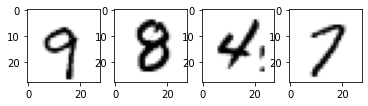

In [80]:
x, y = next(iter(train))
p = model(x)

fig, ax = plt.subplots(1, 4)
ax = ax.flatten()
for i in range(4):
  image = np.reshape(x[0,i,...], (28, 28))
  ax[i].imshow(image, cmap='gray_r')
  
print("target :", int(y[0,...]), "prediction :", int(p[0,...]))